<a href="https://colab.research.google.com/github/D1emonk/My-repo/blob/dev/Lesson_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neptune

In [2]:
!pip install neptune_tensorflow_keras

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import neptune
from sklearn.tree import DecisionTreeClassifier
from neptune.integrations.tensorflow_keras import NeptuneCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree


In [7]:
# Загрузка данных
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/loan_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Инициализация Neptune
run = neptune.init_run(
    project="d1emonk/tutorial",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjYjQ2YTk1Yy00OTllLTQ2ZTctOTAyZi02OGU4NmVhM2Q4NzkifQ==",
)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/d1emonk/tutorial/e/TUT-4


In [9]:
# Кодирование категориальных данных
label_encoders = {}
categorical_columns = ['person_gender', 'person_education', 'person_home_ownership',
                        'loan_intent', 'previous_loan_defaults_on_file']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [10]:
# Разделение данных
X = df.drop('loan_status', axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36000, 13), (9000, 13), (36000,), (9000,))

In [11]:
# Линейная модель с TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Neptune Callback
neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')

In [13]:
# Обучение модели
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[neptune_cbk]
)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7024 - loss: 100.7199 - val_accuracy: 0.8267 - val_loss: 32.6389
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7358 - loss: 67.4495 - val_accuracy: 0.7768 - val_loss: 84.0177
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7324 - loss: 56.2101 - val_accuracy: 0.7771 - val_loss: 73.1024
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7300 - loss: 39.2954 - val_accuracy: 0.7871 - val_loss: 51.1547
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7340 - loss: 48.1095 - val_accuracy: 0.8167 - val_loss: 54.3158
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7303 - loss: 38.2085 - val_accuracy: 0.6639 - val_loss: 8.3298
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7223 - loss: 32.6553 - val_accuracy: 0.6890 - val_loss: 9.0097
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7262 - loss: 33.0463 - v

In [14]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
dt_acc = dt_model.score(X_test, y_test)

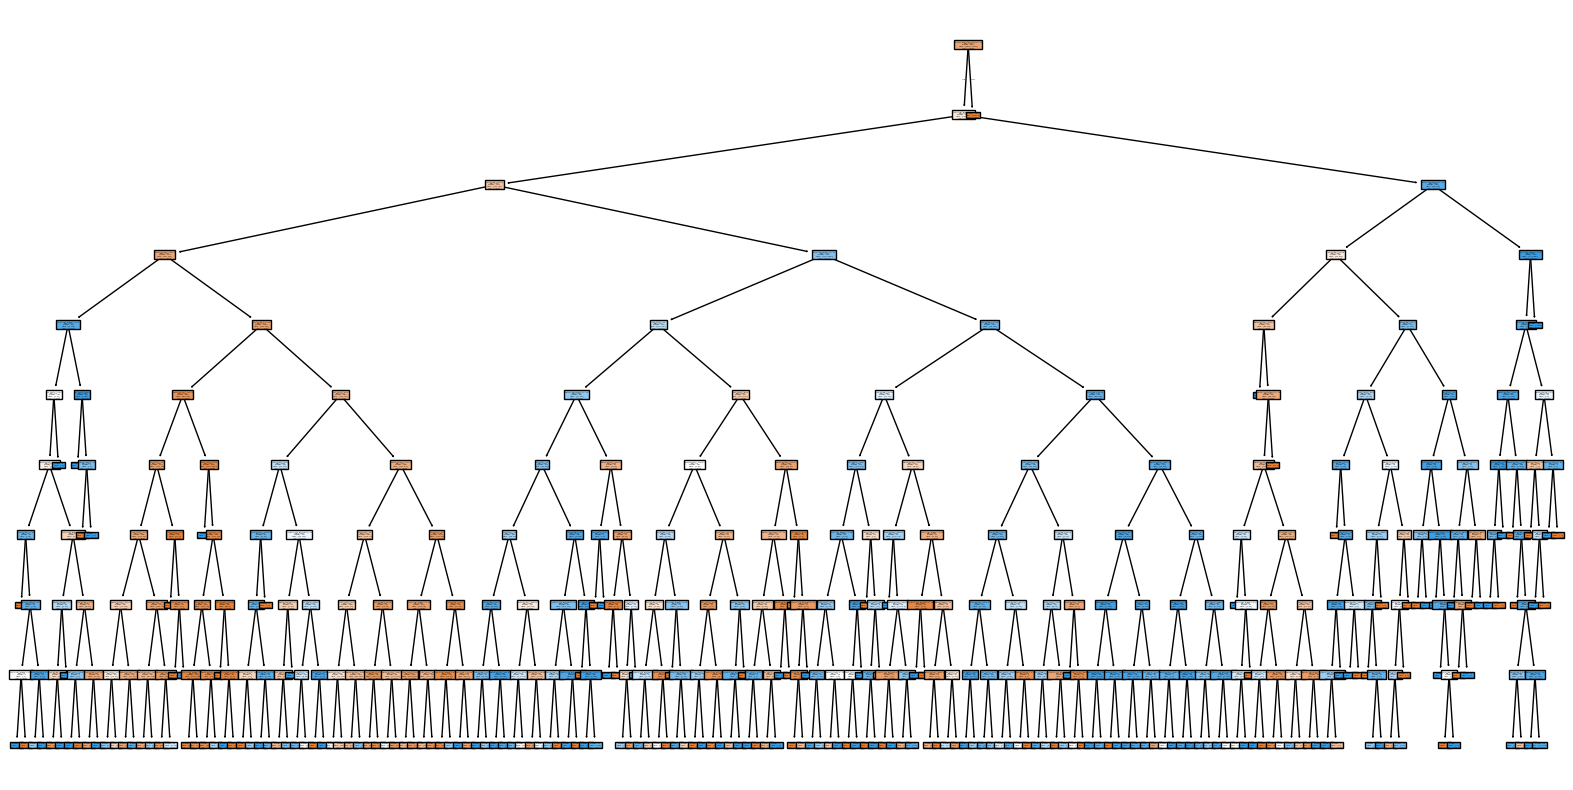

In [19]:
# Визуализация дерева решений
plt.figure(figsize=(20, 10))
tree.plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['Rejected', 'Approved'])
plt.savefig('decision_tree.png')

In [21]:
# Логирование изображения в Neptune
run['decision_tree/visualization'].upload('decision_tree.png')

InactiveRunException: 
[95m
----InactiveRunException----------------------------------------
[0m
It seems you are trying to log metadata to (or fetch it from) a run that was stopped (TUT-4).

Here's what you can do:
    - Resume the run to continue logging to it:
    https://docs.neptune.ai/logging/to_existing_object/
    - Don't invoke `stop()` on a run that you want to access. If you want to stop monitoring only,
    you can resume a run in read-only mode:
    https://docs.neptune.ai/api/connection_modes/#read-only-mode

You may also want to check the following docs pages:
    - https://docs.neptune.ai/logging/to_existing_object/
    - https://docs.neptune.ai/usage/querying_metadata/

[92mNeed help?[0m-> https://docs.neptune.ai/getting_help


In [15]:
# Логирование в Neptune
run['decision_tree/accuracy'] = dt_acc
print(f"Decision Tree Accuracy: {dt_acc}")


Decision Tree Accuracy: 0.914


In [16]:
# Завершение сессии
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/d1emonk/tutorial/e/TUT-4/metadata
